In [1]:
import pybroker
from pybroker import Strategy, StrategyConfig, YFinance
from pybroker.ext.data import AKShare

pybroker.enable_data_source_cache('my_strategy')

akshare = AKShare()

config = StrategyConfig(initial_cash=500_000)

strategy = Strategy(akshare, '3/1/2017', '3/1/2022', config)

但在创建 Strategy 时，没有显式指定 interval，也没有使用 .add_lookback_data(...)。

这说明：

你使用的是 默认的数据频率。

在 pybroker 中，当你使用 AKShare 并且没有指定 interval，默认就是 日线数据，也就是每天一根K线。

# 买卖策略

In [ ]:
def buy_low(ctx):
    # If shares were already purchased and are currently being held, then return.
    if ctx.long_pos():
        print(ctx.long_pos())
        return
    # If the latest close price is less than the previous day's low price,
    # then place a buy order.
    if ctx.bars >= 2 and ctx.close[-1] < ctx.low[-2]:
        # Buy a number of shares that is equal to 25% the portfolio.
        ctx.buy_shares = ctx.calc_target_shares(0.25)
        # Set the limit price of the order.
        ctx.buy_limit_price = ctx.close[-1] - 0.01
        # Hold the position for 3 bars before liquidating (in this case, 3 days).
        ctx.hold_bars = 3

In [ ]:
def buy_and_sell(ctx):
    pos = ctx.long_pos()

    print(f"当前持仓: {pos.shares}")

    # 如果未持仓，且满足“收盘价 < 昨日最低价”，则买入
    if not pos and ctx.bars >= 2 and ctx.close[-1] < ctx.low[-2]:
        ctx.buy_shares = ctx.calc_target_shares(0.25)
        ctx.buy_limit_price = ctx.close[-1] - 0.01

    # 如果已持仓，且当前价格涨超5%，则卖出止盈
    if pos and ctx.close[-1] >= pos.avg_price * 1.05:
        ctx.sell_shares = ctx.calc_target_shares(0.25)


这里ctx.bars是已有的日K线数量

In [3]:
strategy.add_execution(buy_and_sell, ['002318'])

In [4]:
result = strategy.backtest()

Backtesting: 2017-03-01 00:00:00 to 2022-03-01 00:00:00

Loaded cached bar data.

Test split: 2017-03-01 00:00:00 to 2022-03-01 00:00:00


  0% (0 of 1217) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--


AttributeError: 'Position' object has no attribute 'avg_price'

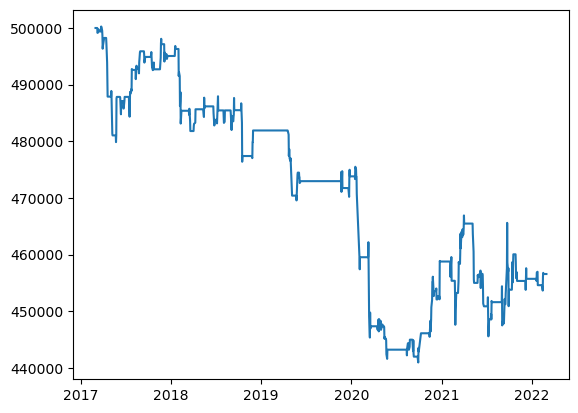

In [5]:
import matplotlib.pyplot as plt

chart = plt.subplot2grid((3, 2), (0, 0), rowspan=3, colspan=2)
chart.plot(result.portfolio.index, result.portfolio['market_value'])

           日期    股票代码    开盘    收盘    最高    最低     成交量          成交额    振幅  \
0  2020-01-02  002318  6.50  6.50  6.64  6.43  200641  190129708.0  3.27   
1  2020-01-03  002318  6.50  6.82  6.92  6.47  253758  246795213.0  6.92   
2  2020-01-06  002318  6.77  6.85  7.18  6.69  284567  281885680.0  7.18   
3  2020-01-07  002318  6.91  6.98  7.00  6.79  184335  182134871.0  3.07   
4  2020-01-08  002318  6.93  6.65  6.98  6.64  195267  190061157.0  4.87   

    涨跌幅   涨跌额   换手率  
0  1.25  0.08  2.45  
1  4.92  0.32  3.10  
2  0.44  0.03  3.48  
3  1.90  0.13  2.25  
4 -4.73 -0.33  2.39  


/home/sun/miniconda3/envs/akshare/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25910 (\N{CJK UNIFIED IDEOGRAPH-6536}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/sun/miniconda3/envs/akshare/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 30424 (\N{CJK UNIFIED IDEOGRAPH-76D8}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/sun/miniconda3/envs/akshare/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/sun/miniconda3/envs/akshare/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 36235 (\N{CJK UNIFIED IDEOGRAPH-8D8B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/sun/miniconda3/envs/akshare/lib/python3.13/site-packages/IPython/core/pylabtoo

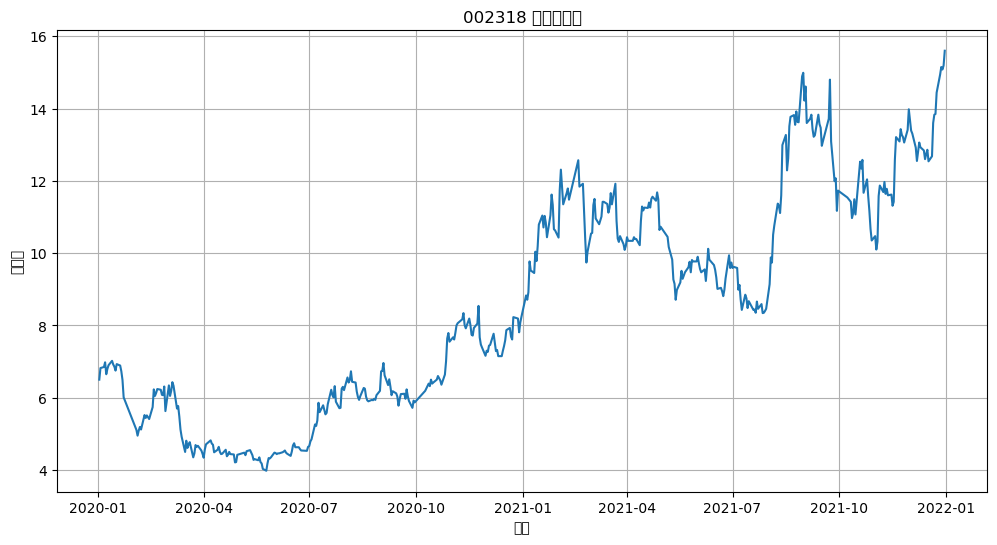

In [11]:
import akshare as ak
import matplotlib.pyplot as plt

# 获取 002318 的历史日线数据
df = ak.stock_zh_a_hist(
    symbol='002318',
    period='daily',
    start_date='20200101',
    end_date='20220101',
    adjust='qfq'  # 可选：'qfq' 前复权，'hfq' 后复权，'' 不复权
)

# 查看前几行
print(df.head())

# 绘制收盘价趋势
df.set_index('日期')['收盘'].plot(title='002318 收盘价趋势', figsize=(12, 6))
plt.xlabel('日期')
plt.ylabel('收盘价')
plt.grid()
plt.show()



In [7]:
result.trades

,type,symbol,entry_date,exit_date,entry,exit,shares,pnl,return_pct,agg_pnl,bars,pnl_per_bar,stop,mae,mfe
id,,,,,,,,,,,,,,,
1,long,002318,2017-03-09,2017-03-14,10.09,10.04,12291,-614.55,-0.50,-614.55,3,-204.85,bar,-0.20,0.09
2,long,002318,2017-03-23,2017-03-28,9.87,9.88,12610,126.10,0.10,-488.45,3,42.03,bar,-0.09,0.10
3,long,002318,2017-03-29,2017-04-05,9.80,9.70,12677,-1267.70,-1.02,-1756.15,3,-422.57,bar,-0.30,0.09
4,long,002318,2017-04-14,2017-04-19,9.69,8.88,12788,-10358.28,-8.36,-12114.43,3,-3452.76,bar,-0.81,0.09
5,long,002318,2017-05-04,2017-05-09,8.48,8.00,14265,-6847.20,-5.66,-18961.63,3,-2282.40,bar,-0.48,0.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,long,002318,2021-10-13,2021-10-18,13.20,13.93,8562,6250.26,5.53,-39956.00,3,2083.42,bar,-0.30,0.78
73,long,002318,2021-10-28,2021-11-02,13.12,12.57,8551,-4703.05,-4.19,-44659.05,3,-1567.68,bar,-0.90,0.32
74,long,002318,2021-12-07,2021-12-10,15.04,15.09,7489,374.45,0.33,-44284.60,3,124.82,bar,-0.44,0.69


In [8]:
result.orders

,type,symbol,date,shares,limit_price,fill_price,fees
id,,,,,,,
1,buy,002318,2017-03-09,12291,10.16,10.09,0.0
2,sell,002318,2017-03-14,12291,NaN,10.04,0.0
3,buy,002318,2017-03-23,12610,9.89,9.87,0.0
4,sell,002318,2017-03-28,12610,NaN,9.88,0.0
5,buy,002318,2017-03-29,12677,9.84,9.80,0.0
...,...,...,...,...,...,...,...
148,sell,002318,2021-12-10,7489,NaN,15.09,0.0
149,buy,002318,2022-01-20,6229,18.28,17.72,0.0
150,sell,002318,2022-01-25,6229,NaN,17.54,0.0


In [9]:
result.metrics_df

,name,value
0,trade_count,76
1,initial_market_value,500000.0
2,end_market_value,456565.31
3,total_pnl,-43434.69
4,unrealized_pnl,0.0
5,total_return_pct,-8.686938
6,total_profit,98936.1
7,total_loss,-142370.79
8,total_fees,0.0
9,max_drawdown,-59321.17
